### Emotion classification with 10 fold cross validation on 6 classes

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, callbacks
from tensorflow.keras import Model, Sequential
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import string

from sklearn.utils import resample

In [2]:
##train_data = pd.read_csv("../input/emotions-dataset-for-nlp/train.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")

df = pd.read_csv("C:/Users/ranja/Desktop/Emotion_final/Emotion_final.csv")

In [3]:
EMBEDDING_FILE= f'C:/Users/ranja/Desktop/Emotion_final/glove.6B.100d.txt' #GloVe file path
EMBEDDING_FILE

'C:/Users/ranja/Desktop/Emotion_final/glove.6B.100d.txt'

In [4]:
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


C:\Users\ranja\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


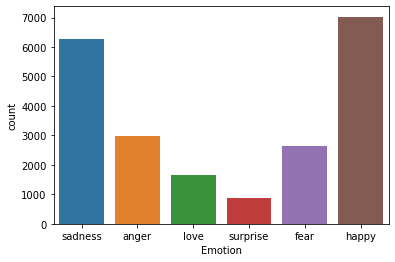

In [5]:
sns.countplot(df.Emotion)
plt.show()

In [6]:
df.isna().sum()

Text       0
Emotion    0
dtype: int64

In [7]:
X=df.drop('Emotion', axis=1)#Input
y=df['Emotion'] #Target

In [8]:
messages = X.copy()
messages.reset_index(inplace=True)
messages

,index,Text
0,0,i didnt feel humiliated
1,1,i can go from feeling so hopeless to so damned...
2,2,im grabbing a minute to post i feel greedy wrong
3,3,i am ever feeling nostalgic about the fireplac...
4,4,i am feeling grouchy
...,...,...
21454,21454,Melissa stared at her friend in dism
21455,21455,Successive state elections have seen the gover...
21456,21456,Vincent was irritated but not dismay
21457,21457,Kendall-Hume turned back to face the dismayed ...


In [9]:
ps = PorterStemmer()
# sno = nltk.stem.SnowballStemmer('english')
lemma = nltk.wordnet.WordNetLemmatizer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['Text'][i]) #Remove Special Characters
    review = review.lower() #Lower case
    review = review.split()
    # review = [lemma.lemmatize(word) for word in review if not word in stopwords.words('english')]
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')] #Remove stopwords
    review = ' '.join(review)
    corpus.append(review)
corpus[:10]

['didnt feel humili',
 'go feel hopeless damn hope around someon care awak',
 'im grab minut post feel greedi wrong',
 'ever feel nostalg fireplac know still properti',
 'feel grouchi',
 'ive feel littl burden late wasnt sure',
 'ive take milligram time recommend amount ive fallen asleep lot faster also feel like funni',
 'feel confus life teenag jade year old man',
 'petrona year feel petrona perform well made huge profit',
 'feel romant']

In [10]:
#Creating the dictionary with word as key and pretrained-value array as value
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE, encoding='utf-8'))

#Calculate mean and std for the pretrained weights
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
print(emb_mean,emb_std)

C:\Users\ranja\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


0.004451992 0.4081574


In [11]:
voc_size=10000 # Vocabulary size
embed_size=100 #word vector size

tokenizer = Tokenizer(num_words=voc_size)
tokenizer.fit_on_texts(list(corpus))
word_index = tokenizer.word_index #Total words in the corpus
nb_words = min(voc_size, len(word_index))

#Initialize weight matrix for embedding layer
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size)) 

for word, i in word_index.items():
    if i >= voc_size: 
        continue #Skip the words if vocab size is reached
    embedding_vector = embeddings_index.get(word) #Extract the pretrained values from GloVe
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [12]:
len(embedding_matrix)

10000

In [ ]:
# corpus_df = pd.DataFrame
# corpus_df= pd.DataFrame(corpus)
# corpus_df.rename(columns={0:'Text'}, inplace=True)
# corpus_df

In [14]:
#one hot 
onehot = [one_hot(words, voc_size) for words in corpus]
#Finding max words
l = 0
for x in corpus:
    l = max(l,len(x.split(' ')))
    
#Padding the sequences for input
sent_length= l
embedded_docs=pad_sequences(onehot,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 9594 3968 2399]
 [   0    0    0 ... 2060 7145 6382]
 [   0    0    0 ... 3968 8113 1100]
 ...
 [   0    0    0 ... 6937 2079 5008]
 [   0    0    0 ... 4526 5008 4301]
 [   0    0    0 ...    0 5008   84]]


In [21]:
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from sklearn import preprocessing
#Encoding the target outputs to integers
label_encoder = preprocessing.LabelEncoder()

X_final=np.array(embedded_docs) #input to array
y = label_encoder.fit_transform(y)
y_final=np.array(y)
print(y_final)

[4 4 0 ... 1 1 1]


In [22]:
X_final.shape,y_final.shape

((21459, 35), (21459,))

In [ ]:
embedded_docs=pad_sequences(onehot,padding='pre',maxlen=l)
print(embedded_docs)

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y

In [ ]:
X_final = np.array(embedded_docs)
X_final

In [ ]:
y = np.array(y)

In [ ]:
print(y)

In [ ]:
type(y)

In [ ]:
X_final.shape,y.shape

In [23]:
#Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, 
                                                    test_size=0.2, random_state=42) 
#Train-Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.1, random_state=21) 

In [24]:
y_test.shape, y_val.shape

((4292,), (1717,))

### Model Building

In [25]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from keras.metrics import Precision, Recall
import tensorflow as tf

In [52]:
from keras.callbacks import EarlyStopping
EarlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1)

Training for fold 1 ...
Epoch 1/20
302/302 [==============================] - 12s 35ms/step - loss: 1.3818 - accuracy: 0.4385 - val_loss: 0.9901 - val_accuracy: 0.6146
Epoch 2/20
302/302 [==============================] - 10s 33ms/step - loss: 0.7747 - accuracy: 0.7130 - val_loss: 0.6945 - val_accuracy: 0.7535
Epoch 3/20
302/302 [==============================] - 10s 34ms/step - loss: 0.5638 - accuracy: 0.7971 - val_loss: 0.6859 - val_accuracy: 0.7554
Epoch 4/20
302/302 [==============================] - 10s 33ms/step - loss: 0.4630 - accuracy: 0.8309 - val_loss: 0.7464 - val_accuracy: 0.7428
Epoch 5/20
302/302 [==============================] - 10s 33ms/step - loss: 0.3937 - accuracy: 0.8533 - val_loss: 0.8344 - val_accuracy: 0.7377
Epoch 6/20
302/302 [==============================] - 10s 33ms/step - loss: 0.3374 - accuracy: 0.8754 - val_loss: 0.8636 - val_accuracy: 0.7339
Epoch 7/20
302/302 [==============================] - 11s 36ms/step - loss: 0.3012 - accuracy: 0.8883 - val_loss

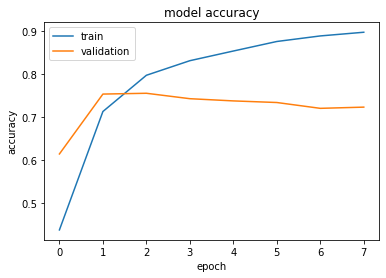

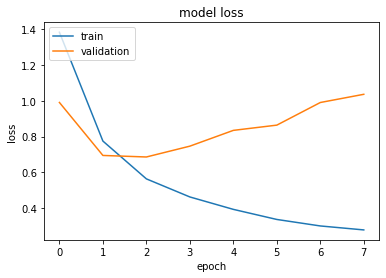

Confusion Matrix


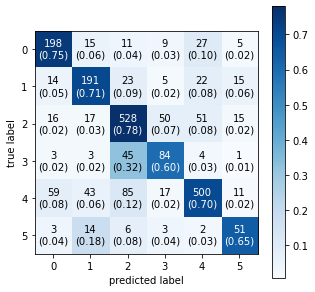

Training for fold 2 ...
Epoch 1/20
302/302 [==============================] - 14s 38ms/step - loss: 1.4191 - accuracy: 0.4320 - val_loss: 1.0542 - val_accuracy: 0.5937
Epoch 2/20
302/302 [==============================] - 11s 36ms/step - loss: 0.8320 - accuracy: 0.6877 - val_loss: 0.7126 - val_accuracy: 0.7386
Epoch 3/20
302/302 [==============================] - 11s 35ms/step - loss: 0.5711 - accuracy: 0.7902 - val_loss: 0.7037 - val_accuracy: 0.7479
Epoch 4/20
302/302 [==============================] - 11s 36ms/step - loss: 0.4608 - accuracy: 0.8294 - val_loss: 0.7363 - val_accuracy: 0.7526
Epoch 5/20
302/302 [==============================] - 11s 36ms/step - loss: 0.3905 - accuracy: 0.8550 - val_loss: 0.7708 - val_accuracy: 0.7512
Epoch 6/20
302/302 [==============================] - 11s 35ms/step - loss: 0.3330 - accuracy: 0.8777 - val_loss: 0.8916 - val_accuracy: 0.7404
Epoch 7/20
302/302 [==============================] - 11s 36ms/step - loss: 0.2915 - accuracy: 0.8911 - val_loss

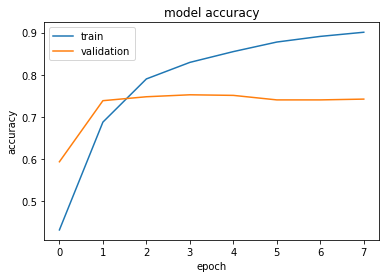

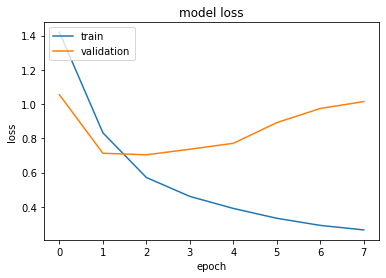

Confusion Matrix


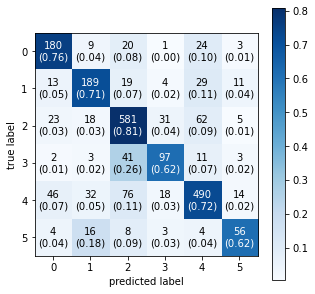

Training for fold 3 ...
Epoch 1/20
302/302 [==============================] - 12s 35ms/step - loss: 1.3964 - accuracy: 0.4292 - val_loss: 1.0184 - val_accuracy: 0.5871
Epoch 2/20
302/302 [==============================] - 10s 34ms/step - loss: 0.7976 - accuracy: 0.7032 - val_loss: 0.6966 - val_accuracy: 0.7456
Epoch 3/20
302/302 [==============================] - 10s 34ms/step - loss: 0.5665 - accuracy: 0.7951 - val_loss: 0.7038 - val_accuracy: 0.7381
Epoch 4/20
302/302 [==============================] - 10s 34ms/step - loss: 0.4644 - accuracy: 0.8293 - val_loss: 0.7301 - val_accuracy: 0.7456
Epoch 5/20
302/302 [==============================] - 10s 33ms/step - loss: 0.3899 - accuracy: 0.8572 - val_loss: 0.7962 - val_accuracy: 0.7460
Epoch 6/20
302/302 [==============================] - 10s 35ms/step - loss: 0.3397 - accuracy: 0.8758 - val_loss: 0.8974 - val_accuracy: 0.7404
Epoch 7/20
302/302 [==============================] - 10s 34ms/step - loss: 0.2951 - accuracy: 0.8922 - val_loss

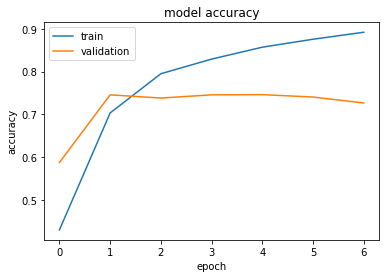

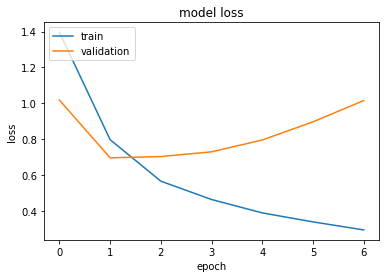

Confusion Matrix


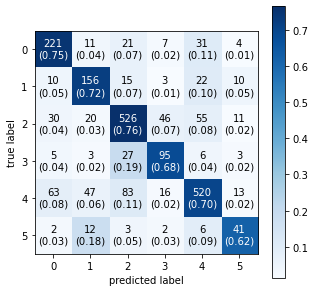

Training for fold 4 ...
Epoch 1/20
302/302 [==============================] - 12s 36ms/step - loss: 1.4120 - accuracy: 0.4280 - val_loss: 0.9652 - val_accuracy: 0.6160
Epoch 2/20
302/302 [==============================] - 10s 34ms/step - loss: 0.8355 - accuracy: 0.6661 - val_loss: 0.8130 - val_accuracy: 0.7064
Epoch 3/20
302/302 [==============================] - 10s 34ms/step - loss: 0.6067 - accuracy: 0.7826 - val_loss: 0.7422 - val_accuracy: 0.7372
Epoch 4/20
302/302 [==============================] - 10s 33ms/step - loss: 0.4882 - accuracy: 0.8244 - val_loss: 0.8034 - val_accuracy: 0.7335
Epoch 5/20
302/302 [==============================] - 10s 34ms/step - loss: 0.4040 - accuracy: 0.8524 - val_loss: 0.8487 - val_accuracy: 0.7344
Epoch 6/20
302/302 [==============================] - 11s 35ms/step - loss: 0.3440 - accuracy: 0.8739 - val_loss: 0.9042 - val_accuracy: 0.7358
Epoch 7/20
302/302 [==============================] - 10s 34ms/step - loss: 0.3000 - accuracy: 0.8887 - val_loss

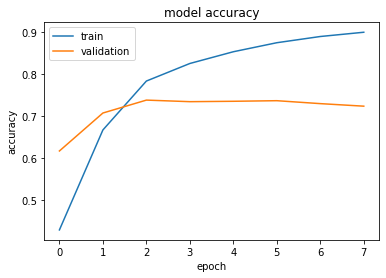

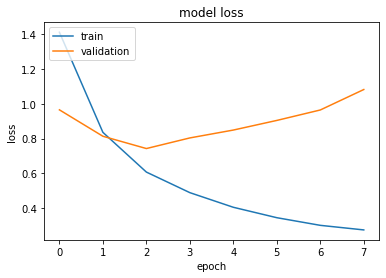

Confusion Matrix


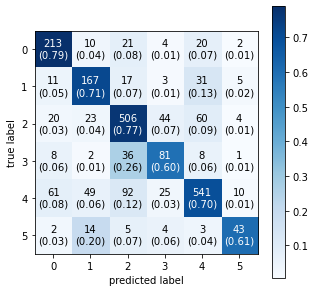

Training for fold 5 ...
Epoch 1/20
302/302 [==============================] - 13s 37ms/step - loss: 1.4175 - accuracy: 0.4154 - val_loss: 0.9935 - val_accuracy: 0.6174
Epoch 2/20
302/302 [==============================] - 11s 35ms/step - loss: 0.8501 - accuracy: 0.6765 - val_loss: 0.7435 - val_accuracy: 0.7237
Epoch 3/20
302/302 [==============================] - 11s 35ms/step - loss: 0.6080 - accuracy: 0.7743 - val_loss: 0.7222 - val_accuracy: 0.7409
Epoch 4/20
302/302 [==============================] - 11s 35ms/step - loss: 0.4892 - accuracy: 0.8202 - val_loss: 0.7304 - val_accuracy: 0.7409
Epoch 5/20
302/302 [==============================] - 10s 34ms/step - loss: 0.4054 - accuracy: 0.8518 - val_loss: 0.8205 - val_accuracy: 0.7269
Epoch 6/20
302/302 [==============================] - 10s 34ms/step - loss: 0.3471 - accuracy: 0.8719 - val_loss: 0.8822 - val_accuracy: 0.7279
Epoch 7/20
302/302 [==============================] - 10s 34ms/step - loss: 0.3061 - accuracy: 0.8874 - val_loss

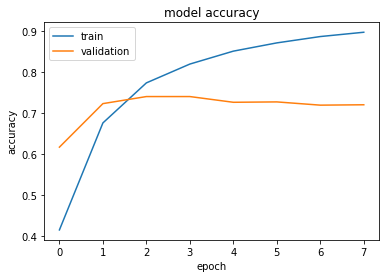

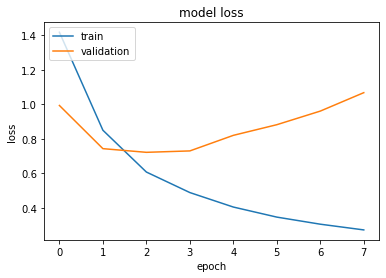

Confusion Matrix


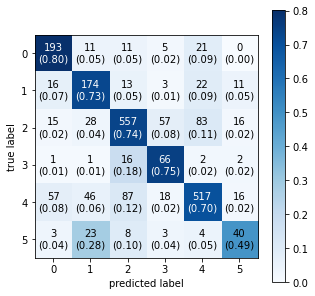

Training for fold 6 ...
Epoch 1/20
302/302 [==============================] - 12s 35ms/step - loss: 1.3705 - accuracy: 0.4422 - val_loss: 0.9782 - val_accuracy: 0.6305
Epoch 2/20
302/302 [==============================] - 10s 34ms/step - loss: 0.7824 - accuracy: 0.7146 - val_loss: 0.7281 - val_accuracy: 0.7377
Epoch 3/20
302/302 [==============================] - 10s 34ms/step - loss: 0.5722 - accuracy: 0.7897 - val_loss: 0.7240 - val_accuracy: 0.7446
Epoch 4/20
302/302 [==============================] - 10s 33ms/step - loss: 0.4667 - accuracy: 0.8290 - val_loss: 0.7854 - val_accuracy: 0.7260
Epoch 5/20
302/302 [==============================] - 10s 33ms/step - loss: 0.3988 - accuracy: 0.8537 - val_loss: 0.8440 - val_accuracy: 0.7274
Epoch 6/20
302/302 [==============================] - 10s 34ms/step - loss: 0.3394 - accuracy: 0.8756 - val_loss: 0.9366 - val_accuracy: 0.7311
Epoch 7/20
302/302 [==============================] - 10s 33ms/step - loss: 0.3027 - accuracy: 0.8888 - val_loss

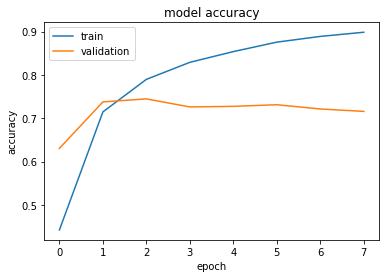

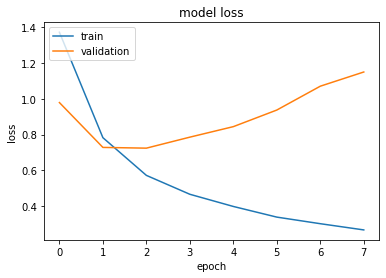

Confusion Matrix


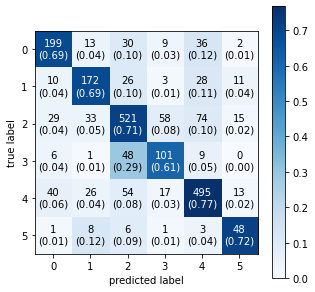

Training for fold 7 ...
Epoch 1/20
302/302 [==============================] - 12s 36ms/step - loss: 1.3599 - accuracy: 0.4594 - val_loss: 0.9710 - val_accuracy: 0.6160
Epoch 2/20
302/302 [==============================] - 10s 34ms/step - loss: 0.7949 - accuracy: 0.7073 - val_loss: 0.7246 - val_accuracy: 0.7269
Epoch 3/20
302/302 [==============================] - 10s 33ms/step - loss: 0.5712 - accuracy: 0.7906 - val_loss: 0.7147 - val_accuracy: 0.7404
Epoch 4/20
302/302 [==============================] - 10s 33ms/step - loss: 0.4678 - accuracy: 0.8280 - val_loss: 0.7618 - val_accuracy: 0.7349
Epoch 5/20
302/302 [==============================] - 10s 32ms/step - loss: 0.3961 - accuracy: 0.8547 - val_loss: 0.8320 - val_accuracy: 0.7218
Epoch 6/20
302/302 [==============================] - 10s 32ms/step - loss: 0.3346 - accuracy: 0.8766 - val_loss: 0.9063 - val_accuracy: 0.7246
Epoch 7/20
302/302 [==============================] - 10s 33ms/step - loss: 0.3020 - accuracy: 0.8884 - val_loss

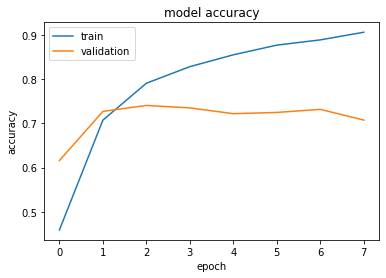

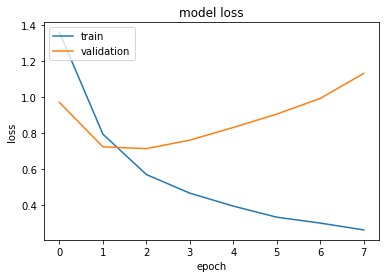

Confusion Matrix


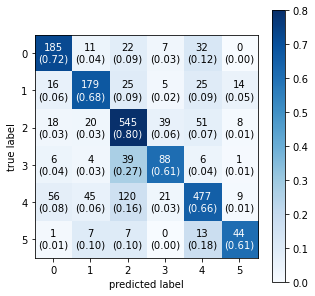

Training for fold 8 ...
Epoch 1/20
302/302 [==============================] - 12s 35ms/step - loss: 1.3811 - accuracy: 0.4374 - val_loss: 1.0157 - val_accuracy: 0.6011
Epoch 2/20
302/302 [==============================] - 10s 34ms/step - loss: 0.7769 - accuracy: 0.7092 - val_loss: 0.7100 - val_accuracy: 0.7418
Epoch 3/20
302/302 [==============================] - 10s 33ms/step - loss: 0.5570 - accuracy: 0.7986 - val_loss: 0.7178 - val_accuracy: 0.7484
Epoch 4/20
302/302 [==============================] - 10s 33ms/step - loss: 0.4617 - accuracy: 0.8320 - val_loss: 0.7746 - val_accuracy: 0.7377
Epoch 5/20
302/302 [==============================] - 10s 34ms/step - loss: 0.3908 - accuracy: 0.8546 - val_loss: 0.8401 - val_accuracy: 0.7335
Epoch 6/20
302/302 [==============================] - 10s 35ms/step - loss: 0.3414 - accuracy: 0.8731 - val_loss: 0.8960 - val_accuracy: 0.7293
Epoch 7/20
302/302 [==============================] - 10s 34ms/step - loss: 0.3018 - accuracy: 0.8888 - val_loss

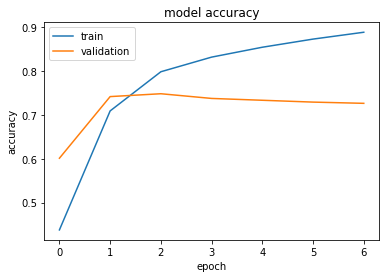

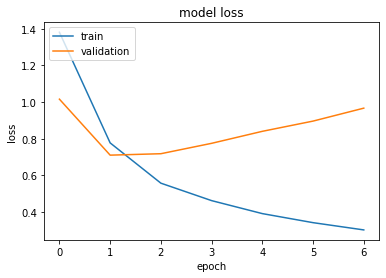

Confusion Matrix


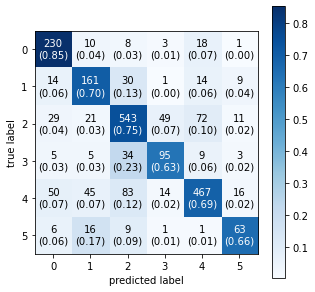

Training for fold 9 ...
Epoch 1/20
302/302 [==============================] - 12s 36ms/step - loss: 1.3634 - accuracy: 0.4531 - val_loss: 0.9912 - val_accuracy: 0.6067oss: 1.3833 
Epoch 2/20
302/302 [==============================] - 10s 35ms/step - loss: 0.8122 - accuracy: 0.6741 - val_loss: 0.8160 - val_accuracy: 0.7088
Epoch 3/20
302/302 [==============================] - 10s 33ms/step - loss: 0.5927 - accuracy: 0.7853 - val_loss: 0.7297 - val_accuracy: 0.7484
Epoch 4/20
302/302 [==============================] - 10s 32ms/step - loss: 0.4676 - accuracy: 0.8313 - val_loss: 0.7666 - val_accuracy: 0.7367
Epoch 5/20
302/302 [==============================] - 10s 32ms/step - loss: 0.3869 - accuracy: 0.8575 - val_loss: 0.8218 - val_accuracy: 0.7335
Epoch 6/20
302/302 [==============================] - 10s 34ms/step - loss: 0.3420 - accuracy: 0.8740 - val_loss: 0.9466 - val_accuracy: 0.7223
Epoch 7/20
302/302 [==============================] - 11s 37ms/step - loss: 0.2960 - accuracy: 0.890

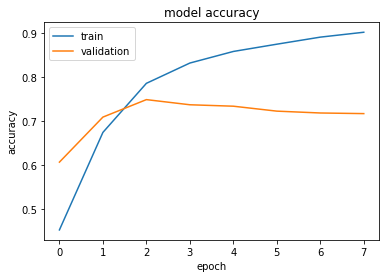

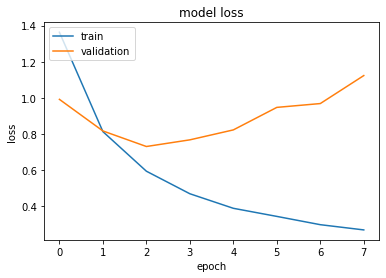

Confusion Matrix


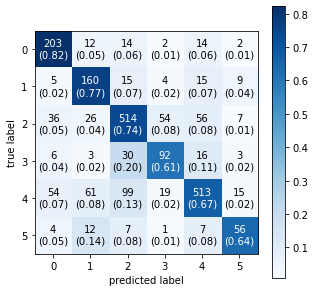

Training for fold 10 ...
Epoch 1/20
302/302 [==============================] - 12s 36ms/step - loss: 1.4127 - accuracy: 0.4188 - val_loss: 1.0176 - val_accuracy: 0.6098
Epoch 2/20
302/302 [==============================] - 10s 33ms/step - loss: 0.7949 - accuracy: 0.7058 - val_loss: 0.7151 - val_accuracy: 0.7389
Epoch 3/20
302/302 [==============================] - 10s 33ms/step - loss: 0.5729 - accuracy: 0.7884 - val_loss: 0.7140 - val_accuracy: 0.7352
Epoch 4/20
302/302 [==============================] - 10s 33ms/step - loss: 0.4742 - accuracy: 0.8278 - val_loss: 0.7417 - val_accuracy: 0.7352
Epoch 5/20
302/302 [==============================] - 10s 32ms/step - loss: 0.4068 - accuracy: 0.8524 - val_loss: 0.8007 - val_accuracy: 0.7352
Epoch 6/20
302/302 [==============================] - 10s 34ms/step - loss: 0.3493 - accuracy: 0.8702 - val_loss: 0.8480 - val_accuracy: 0.7319
Epoch 7/20
302/302 [==============================] - 10s 32ms/step - loss: 0.3087 - accuracy: 0.8864 - val_los

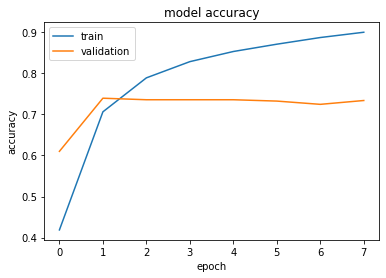

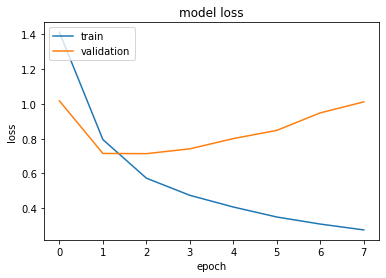

Confusion Matrix


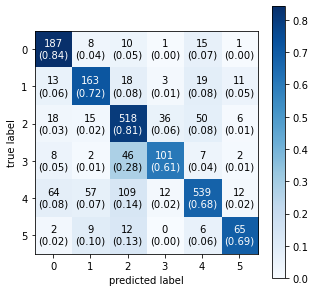

In [59]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)


# K-fold Cross Validation model evaluation
fold_no = 1
acc_per_fold=[]
loss_per_fold=[]
for train, test in kfold.split(X_final, y):
    model = Sequential()

    model.add(Embedding(input_dim=voc_size, output_dim =100 ,input_length=35))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

# model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
# model.add(MaxPooling1D(pool_size=5))
# #model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))

    model.add(Dense(6, activation='softmax'))
    #compiling model
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    print(f'Training for fold {fold_no} ...')
                    
    #fit the data to model
    hist = model.fit(X_final[train], y[train],
                     epochs=20,
                     batch_size=64,
                    validation_data=(X_final[test], y[test]),
                     verbose=1,
                    callbacks=[EarlyStop])
     # Generate generalization metrics
    scores = model.evaluate(X_final[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])    
 #   print(hist.history.keys())
 #  "Accuracy"
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # "Loss"
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    pred=model.predict(X_final[test])
    classes_x=np.argmax(pred,axis=1)
    #Accuracy score
    #print('Accuracy score'accuracy_score(classes_x, y[test]))
    
    #Confusion Matrix
    print('Confusion Matrix')
    cm = (confusion_matrix(classes_x, y[test]))
    fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(5,5),
    show_absolute = True,
    show_normed = True,
    colorbar = True)
    plt.show()
    #print(classification_report(p, test_y))
    
 # Increase fold number
    fold_no = fold_no + 1
    